In [5]:
import tensorflow as tf
import glob
import os

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_train\*.png"))
seg_train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_train\*.png"))

test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_test\*.png"))
seg_test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_test\*.png"))

val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_validate\*.png"))
seg_val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_validate\*.png"))

In [6]:
train = tf.data.Dataset.from_tensor_slices(train_dir)
test = tf.data.Dataset.from_tensor_slices(test_dir)
val = tf.data.Dataset.from_tensor_slices(val_dir)

train = train.shuffle(len(train_dir))
test = test.shuffle(len(test_dir))
val = val.shuffle(len(val_dir))

def process_path(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.image.resize(img, (256,256))
    img = tf.cast(img, tf.float32) - 127.5
    img = img / 127.5

    return img

train = train.map(process_path).batch(16)
test = test.map(process_path).batch(16)
val = val.map(process_path).batch(16)

train_count = 0
test_count = 0

train_images = train.take(50)
real_images = tf.convert_to_tensor(list(train_images.as_numpy_iterator()))

(256, 256)


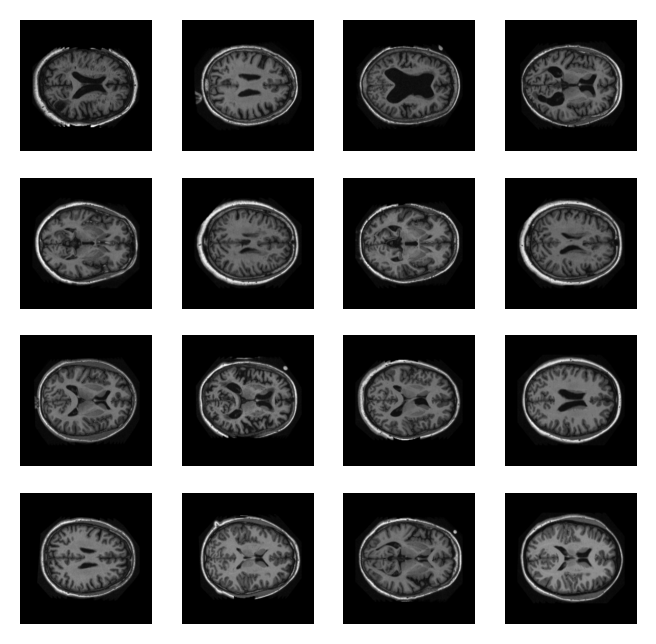

In [48]:
import matplotlib.pyplot as plt 

def display(images):
    fig = plt.figure(figsize=(4,4), dpi=200)
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        for j in range(16):
            plt.imshow(images[i], cmap = 'gray')
            plt.axis('off')
            
    plt.savefig('real_batch.png')
    plt.show()
    
for img in train.take(1):
    display([tf.squeeze(img)][0])

In [49]:
from tensorflow.keras import layers

image_res = (256,256)

def make_generator_model():
    model = tf.keras.Sequential()
        
    model.add(layers.Dense(image_res[0] // 8 * image_res[1] // 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_res[0] // 8, image_res[1] // 8, 256)))
    
    assert model.output_shape == (None, image_res[0] // 8, image_res[1] // 8, 256)

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 4, image_res[1] // 4, 128)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 2, image_res[1] // 2, 64)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    assert model.output_shape == (None, image_res[0], image_res[1], 1)
        
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[image_res[0], image_res[1], 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
        
    return model

In [50]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [51]:
generator = make_generator_model()
discriminator = make_discriminator_model()

checkpoint_prefix = os.path.join('./checkpoints/', "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [11]:
seed = tf.random.normal([16, 100])

gen_history = tf.Variable(0.00)
disc_history = tf.Variable(0.00)

@tf.function
def train_step(images):
    noise = tf.random.normal([16, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_history.assign(gen_loss)
    disc_history.assign(disc_loss)
    
    gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
from IPython import display

def load_checkpoint():
    checkpoint.restore(tf.train.latest_checkpoint('./checkpoints/'))
    
def model_loss_graph(gen_history, disc_history, save):
    plt.plot(gen_history)
    plt.plot(disc_history)
    
    plt.title('Generator and Discriminator Loss Per Epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['generator', 'discriminator'], loc='upper left')
    if (save):
        plt.savefig("loss_graph.png")
    plt.show()


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    
    prediction = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4), dpi=200)
    
    for i in range(prediction.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('epoch_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
def current_ssim(generator):
    temp_ssim = []
    generated_image = generator(seed, training=False)
    
    for i in range(len(real_images)):
        temp_ssim.append(tf.image.ssim(generated_image, real_images[i], max_val=2))
        
    return tf.math.reduce_max(temp_ssim).numpy()

def generate_ssim_graph(ssim_list):
    plt.plot(ssim_list)
    plt.title("Max SSIM of Generated Image vs Training Set Per Epoch")
    plt.ylabel('SSIM')
    plt.xlabel('Epoch')
    plt.savefig("ssim_graph.png")
    plt.show()

In [13]:
import time
    
def train_model(dataset, epochs):
    ssim_list = list()
    gen_loss_list = list()
    disc_loss_list = list()
    
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        ssim_list.append(current_ssim(generator))
        gen_loss_list.append(gen_history.numpy())
        disc_loss_list.append(disc_history.numpy())
        model_loss_graph(gen_loss_list, disc_loss_list, False)
        
        print("Gen Hist: ", gen_loss_list,"\nDisc Hist: ", disc_loss_list)
        print("Current Epoch: ", epoch + 1)
        print("Last SSIM: ", ssim_list[-1])
        print ('Time For Last Epoch Was {} sec'.format(time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_ssim_graph(ssim_list)
    model_loss_graph(gen_loss_list, disc_loss_list, True)
    generate_and_save_images(generator, epochs, seed)

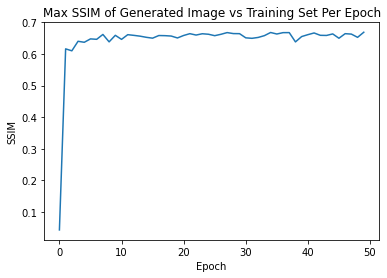

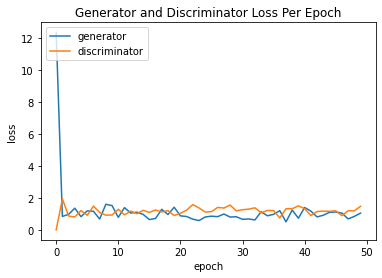

<Figure size 432x288 with 0 Axes>

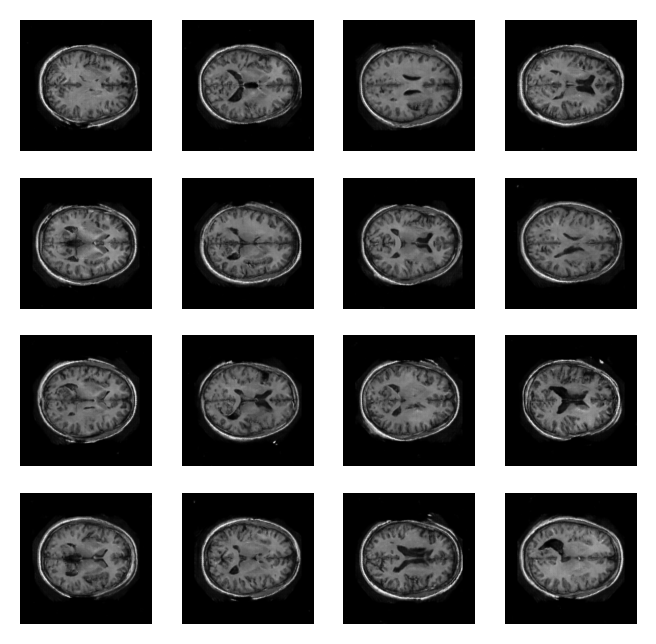

In [386]:
train_model(train, 50)

In [28]:
import imageio

def gif_generator():
    images = []
    filenames = glob.glob("D:\epoch_images\*.png")    
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('model_progress.gif', images)

In [29]:
gif_generator()